# Viewing the dataset

This notebook demonstrates how to access metadata and arrays from the HDF5 dataset.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

Make sure to update the filepath in the block below!

In [2]:
h5_filepath = '/data/bwedig/mejiro/roman_data_challenge_mini_dev/06/roman_data_challenge_mini_v_0_1.h5'  # TODO update this path!
f = h5py.File(h5_filepath, 'r')

The dataset is structured in the following way:

* `images`
    * `strong_lens_00000001`
        * `exposure_00000001_F106` dataset with the F106 exposure, a (91, 91) array
        * `exposure_00000001_F129`
        * ...
    * `strong_lens_00000002` dataset with the SNR per pixel, a (91, 91) array

In [3]:
# print all attributes for the root group
for key, value in f.attrs.items():
    print(f"{key}: {value}")

author: ['bwedig@galileo.physics.wustl.edu' 'username@host for calculation']
created: 2025_09_18-06_57_05_PM
dataset_version: 0.1
galsim_version: ['2.5.1' 'GalSim version']
lenstronomy_version: ['1.13.2' 'lenstronomy version']
mejiro_version: ['2.0.2' 'mejiro version']
slsim_version: ['0.1.0' 'SLSim version']
stpsf_version: ['2.0.0' 'STPSF version']


The `images` group contains a group for each strong lens.

In [4]:
# list the first 10 groups in the 'images' group
images_group = f['images']
pprint(list(images_group.keys())[:10])

['strong_lens_00000000',
 'strong_lens_00000001',
 'strong_lens_00000002',
 'strong_lens_00000003',
 'strong_lens_00000004',
 'strong_lens_00000005',
 'strong_lens_00000006',
 'strong_lens_00000007',
 'strong_lens_00000008',
 'strong_lens_00000009']


Each strong lens group contains the exposures in each filter. It also carries information about the system (redshifts, Einstein radius, etc.) and its observation (Roman detector, detector position).

In [5]:
strong_lens = images_group['strong_lens_00000000']

for attr_key, attr_value in strong_lens.attrs.items():
    print(f"{attr_key}: {attr_value}")

print(f'\nData: {list(strong_lens.keys())}')

LOS_normalization: ['1.0' 'See pyHalo documentation']
concentration_model_fieldhalos: ['LUDLOW2016' 'See pyHalo documentation']
concentration_model_subhalos: ['LUDLOW2016' 'See pyHalo documentation']
detector: ['1' 'Detector']
detector_position_x: ['3679' 'Detector X position']
detector_position_y: ['1226' 'Detector Y position']
log_mhigh: ['12' 'See pyHalo documentation']
log_mlow: ['6' 'See pyHalo documentation']
main_halo_mass: ['9993427529622.21' 'Lens galaxy main halo mass [M_sun]']
mu: ['3.2965869809348654' 'Flux-weighted magnification of source']
r_tidal: ['0.5' 'See pyHalo documentation']
shmf_log_slope: ['-1.9' 'See pyHalo documentation']
sigma_sub: ['0.055' 'See pyHalo documentation']
sigma_v: ['159.6267429783727' 'Lens galaxy velocity dispersion [km/s]']
substructure: ['True' 'Is substructure present in this lens?']
theta_e: ['0.5415263707511598' 'Einstein radius [arcsec]']
uid: ['00000000' 'Unique identifier for system assigned by mejiro']
z_lens: ['0.7659999999999993' 'Len

The attributes of each exposure contains filter-specific quantities such as magnitudes and SNR.

In [6]:
for attr_key, attr_value in strong_lens['exposure_00000000_F106'].attrs.items():
    print(f"{attr_key}: {attr_value}")

exposure_time: ['642' 'Exposure time [seconds]']
filter: ['F106' 'Filter']
fov: ['10.01' 'Field of view [arcsec]']
lens_magnitude: ['21.00228773096724' 'Lens galaxy magnitude']
lensed_source_magnitude: ['23.15338225420355' 'Lensed source galaxy magnitude']
pixel_scale: ['0.11' 'Pixel scale [arcsec/pixel]']
snr: ['24.612181888359718' 'Signal-to-noise ratio']
source_magnitude: ['24.44854360209107' 'Unlensed source galaxy magnitude']
units: ['Counts/sec' 'Units of pixel values']


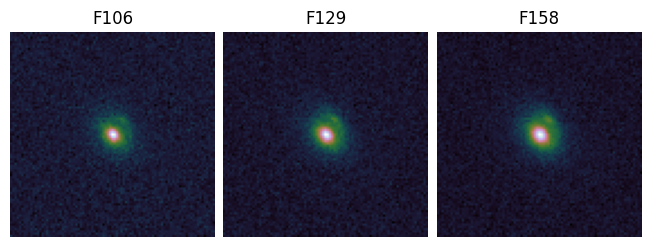

In [7]:
_, ax = plt.subplots(1, len(list(strong_lens.keys())), constrained_layout=True)

for i, (data_key, data_value) in enumerate(strong_lens.items()):
    ax[i].imshow(np.log10(data_value), cmap='cubehelix')
    ax[i].set_title(strong_lens[data_key].attrs['filter'][0])
    ax[i].axis('off')

plt.show()

# Example: label systems with Einstein radius

In [8]:
from astropy.visualization import make_lupton_rgb

data, labels = [], []
for strong_lens_group in images_group.keys():
    id = images_group[strong_lens_group].attrs['uid'][0]
    einstein_radius = images_group[strong_lens_group].attrs['theta_e'][0]
    exposure_r = images_group[strong_lens_group][f'exposure_{id}_F158']
    exposure_g = images_group[strong_lens_group][f'exposure_{id}_F129']
    exposure_b = images_group[strong_lens_group][f'exposure_{id}_F106']

    exposure_r = (exposure_r[:] - np.min(exposure_r[:])) / (np.max(exposure_r[:]) - np.min(exposure_r[:]))
    exposure_g = (exposure_g[:] - np.min(exposure_g[:])) / (np.max(exposure_g[:]) - np.min(exposure_g[:]))
    exposure_b = (exposure_b[:] - np.min(exposure_b[:])) / (np.max(exposure_b[:]) - np.min(exposure_b[:]))
    exposure = make_lupton_rgb(image_r=exposure_r, image_g=exposure_g, image_b=exposure_b, stretch=0.2, Q=4)

    data.append(exposure)
    labels.append(einstein_radius)

print(f'data: {np.array(data).shape}, labels: {np.array(labels).shape}')

data: (10737, 91, 91, 3), labels: (10737,)


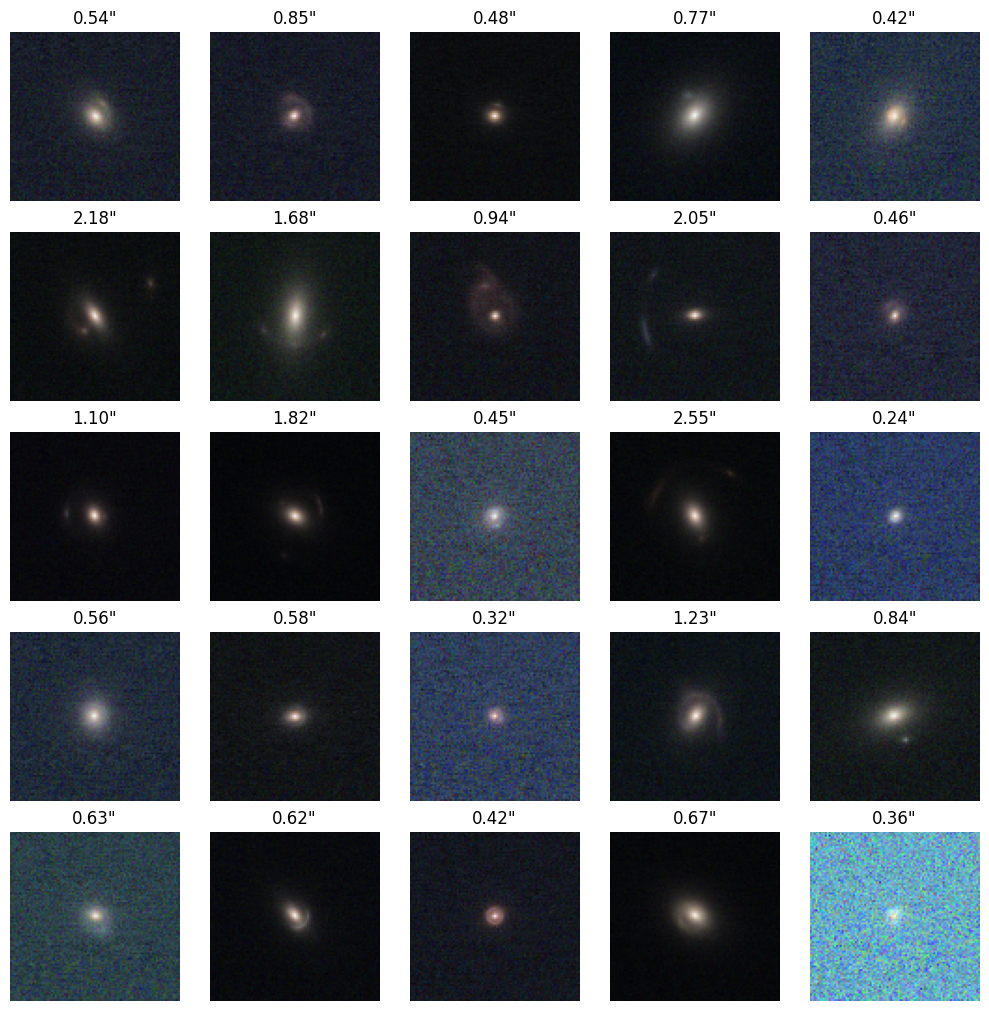

In [9]:
grid_size = 5
_, ax = plt.subplots(grid_size, grid_size, figsize=(10, 10), constrained_layout=True)

for i, (exposure, einstein_radius) in enumerate(zip(data[:grid_size ** 2], labels[:grid_size ** 2])):
    ax[i // grid_size, i % grid_size].imshow(exposure)
    ax[i // grid_size, i % grid_size].set_title(f'{float(einstein_radius):.2f}"')
    ax[i // grid_size, i % grid_size].axis('off')

plt.show()

# Example: create a TensorFlow Dataset from F129 exposures labeled with `substructure` flag

In [10]:
filter = 'F129'

data, labels = [], []
for strong_lens_group in images_group.keys():
    id = images_group[strong_lens_group].attrs['uid'][0]
    substructure_flag = images_group[strong_lens_group].attrs['substructure'][0]
    exposure = images_group[strong_lens_group][f'exposure_{id}_{filter}']

    data.append(exposure)
    labels.append(1 if substructure_flag == 'True' else 0)

print(f'data: {np.array(data).shape}, labels: {np.array(labels).shape}')

data: (10737, 91, 91), labels: (10737,)


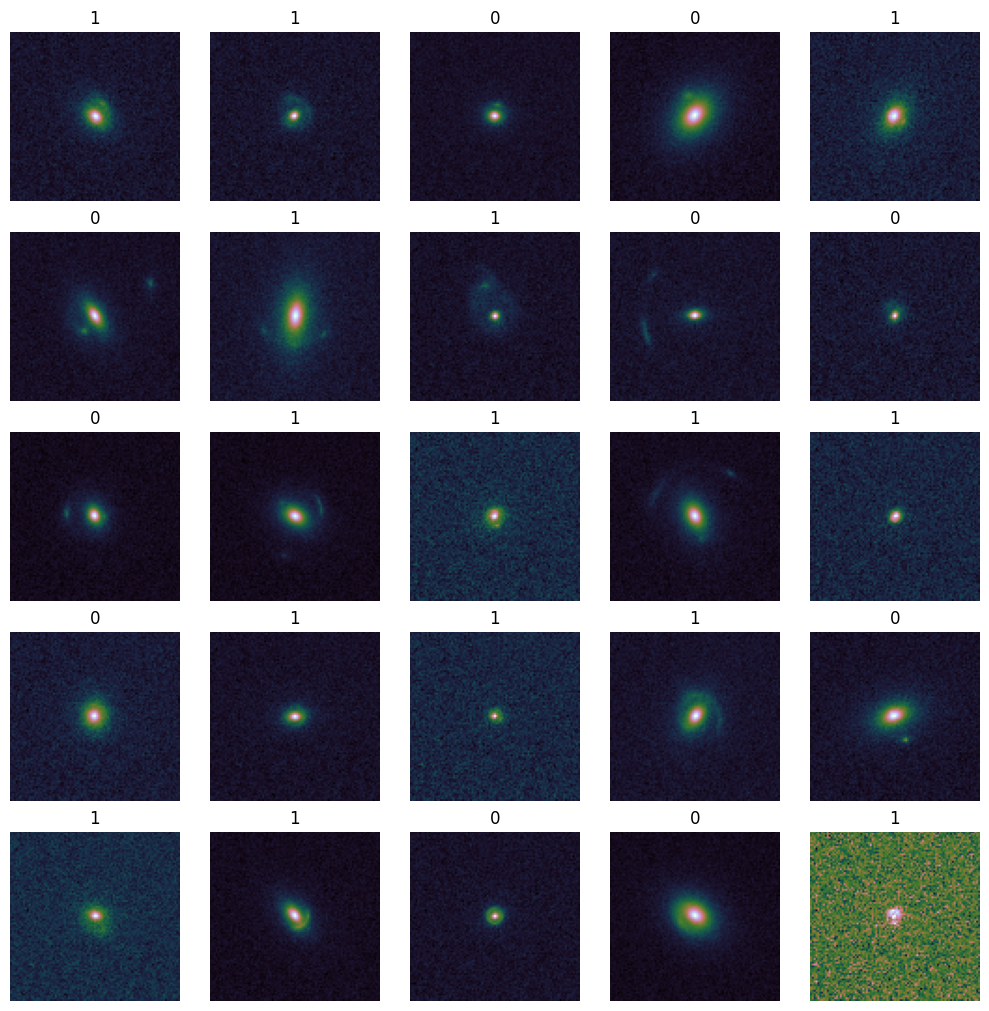

In [11]:
grid_size = 5
_, ax = plt.subplots(grid_size, grid_size, figsize=(10, 10), constrained_layout=True)

for i, (exposure, substructure_flag) in enumerate(zip(data[:grid_size ** 2], labels[:grid_size ** 2])):
    ax[i // grid_size, i % grid_size].imshow(np.log10(exposure), cmap='cubehelix')
    ax[i // grid_size, i % grid_size].set_title(substructure_flag)
    ax[i // grid_size, i % grid_size].axis('off')

plt.show()

Then,

```
from tensorflow import data as tf_data

ds = tf_data.Dataset.from_tensor_slices((data, labels))
```